## Checkpoint II


Group members: Gregory Ho, Jonathan Juarez, Sarah Walker, Yueyue Wang

(Alphabetic order of first name)

Our submission of for Checkpoint 2 consist of two notebooks. This is the first notebook.

This notebook contains a summary of the steps we took in the data cleaning and feature engineering segment of our project

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving train.csv to train.csv


In [ ]:
#load the data
df_train = pd.read_csv('train.csv')

#**Data Cleaning Steps:**

1.   Imputing NAN values in v2a1 - monthly rent payment
2.   Cleaning Columns Dependency, Edjefe and Edjefa
3.   Zerorize NAN values in v18q1 - Number of tablets household owns [HH Level var]
4.   Drop 15 rows where family has no head of household
5.   Assign class based on lowest target for the 85 households where members have different poverty class assignment


## 1.) Imputing NAN values in v2a1

In our first checkpoint, we identified 6860 null values associated with the variable v2a1 (monthly rent payment).

As targets map to classes that represent different levels of household well-being, any consumption-based measure of welfare must include the value that households derive from their dwellings[1]. While the flow of services enjoyed by households living in a dwelling can be correctly approximated by the monthly rental payment to landlords among tenants, no such measure is readily available for home-owners. In most developing countries, housing expenditure typically constitutes 30% of total household expenditure. Thus excluding estimated rental prices from the welfare aggregate used in distributional studies may undermine the validity of comparisons of distributional outcomes[2].

In this segment, we impute monthly rent payments for all 6860 null values based on region, and household class ('Target'). At the same time, a new column ('Imputed rent') is also created to represent the wellfare gains of households owning the home they reside in (security of tenure, etc.).



**Citations:**

[1] Deaton, Angus, and Salman Zaidi. Guidelines for constructing consumption aggregates for welfare analysis. Vol. 135. World Bank Publications, 2002.

[2] Frick, Joachim R., Markus M. Grabka, Timothy M. Smeeding, and Panos Tsakloglou. "Distributional effects of imputed rents in five European countries." Journal of Housing economics 19, no. 3 (2010): 167-179.

In [ ]:
# Copy the data
data = df_train.copy()

# Fill in zero for homeowners
data.loc[data['tipovivi1'] == 1, 'v2a1'] = 0

# Rename the region columns
lugar_cols = {'lugar1': 'Central', 'lugar2': 'Chorotega', 'lugar3': 'Paci­fico Central',
              'lugar4': 'Brunca', 'lugar5': 'Huetar Atlantica', 'lugar6': 'Huetar Norte'}
data = data.rename(columns=lugar_cols)

# Group the data by regions and Target
grouped_data = data.groupby(['Central', 'Chorotega', 'Paci­fico Central', 'Brunca', 'Huetar Atlantica', 'Huetar Norte', 'Target'])

# Compute the median value of v2a1 for each region and Target
median_v2a1_by_region_target = grouped_data['v2a1'].median()

# Fill in the missing null values for v2a1 with the median value of the corresponding region and 'Target'
data['v2a1'] = data.apply(lambda row: median_v2a1_by_region_target[row['Central'], row['Chorotega'], row['Paci­fico Central'], row['Brunca'], row['Huetar Atlantica'], row['Huetar Norte'], row['Target']]
                          if pd.isnull(row['v2a1']) else row['v2a1'], axis=1)

# Fill in zero for homeowners, precarious, and assigned/borrowed housing
data.loc[(data['tipovivi1'] == 1) | (data['tipovivi4'] == 1) | (data['tipovivi5'] == 1), 'v2a1'] = 0

# Assign imputed_rent based on whether the household owns the house, in precarious or assigned/borrowed housing
data['imputed_rent'] = data.apply(lambda row: median_v2a1_by_region_target[row['Central'], row['Chorotega'], row['Paci­fico Central'], row['Brunca'], row['Huetar Atlantica'], row['Huetar Norte'], row['Target']]
                                  if (row['tipovivi1'] == 1 or row['tipovivi4'] or row['tipovivi5'] == 1) else 0, axis=1)


In [ ]:
# Along with the 6 separate columns for each region, we create one column called "region"
# which is categorical and indicates the household region

lugar_cols = {'lugar1': 'Central', 'lugar2': 'Chorotega', 'lugar3': 'Paci­fico Central',
              'lugar4': 'Brunca', 'lugar5': 'Huetar Atlantica', 'lugar6': 'Huetar Norte'}
data = data.rename(columns=lugar_cols)

data.loc[data.loc[:, "Central"]==1, "region"] = "Central"
data.loc[data.loc[:, "Chorotega"]==1, "region"] = "Chorotega"
data.loc[data.loc[:, "Paci­fico Central"]==1, "region"] = "Pacifico Central"
data.loc[data.loc[:, "Brunca"]==1, "region"] = "Brunca"
data.loc[data.loc[:, "Huetar Atlantica"]==1, "region"] = "Huetar Atlantica"
data.loc[data.loc[:, "Huetar Norte"]==1, "region"] = "Huetar Norte"

In [ ]:
# Sanity Check
# Crosstab
ct = data[['Central', 'Chorotega', 'Paci­fico Central', 'Brunca', 'Huetar Atlantica', 'Huetar Norte', 'Target', 'v2a1']]

ct = ct.melt(id_vars=['Target', 'v2a1'], var_name='Region', value_name='Value')
ct = ct[ct['Value'] == 1].drop('Value', axis=1)

# summarize
v2a1_summary = pd.pivot_table(ct, values='v2a1', index='Region', columns='Target', aggfunc=['mean', 'std'])
print(v2a1_summary)

                           mean                                            \
Target                        1             2             3             4   
Region                                                                      
Brunca             11734.693878   8305.714286  19977.339286  21377.339901   
Central            22072.286154  30386.450798  35967.477273  76040.617385   
Chorotega          10649.350649  15155.279503  13247.863248  50203.438795   
Huetar Atlantica    9660.194175   8967.136150  10349.650350  18504.566210   
Huetar Norte        3043.478261   7470.238095  19743.119266  28521.176471   
Paci­fico Central  31649.349398  21757.812500  10803.571429  56057.318681   

                            std                                             
Target                        1             2             3              4  
Region                                                                      
Brunca             28898.168536  22458.888915  35942.913097   59653.056828 

## 2.) Cleaning columns dependency, edjefe and edjefa

Following feedback from Checkpoint I, we refered to several other Kaggle submissions to decide how to treat dependency, edjefe and edjefa. "No" values are replaced with 0 years of education, and "Yes" values with the mean of all individuals in the dataframe.

In [ ]:
# code to clean the "edjefe" and "edjefa" columns

#convert "edjefe" and "edjefa" values from "no" to 0
data.loc[data.loc[:, "edjefe"] == "no","edjefe"] = 0
data.loc[data.loc[:, "edjefa"] == "no","edjefa"] = 0
data.loc[data.loc[:, "dependency"] == "no","dependency"] = 0

#convert "edjefe" and "edjefa" values from "yes" to mean of the education values
edjefe_meaned = data.loc[data.loc[:, "edjefe"] != "yes", "edjefe"].astype("int").mean().astype("int")
edjefe_meaned.astype("object")
data.loc[data.loc[:, "edjefe"]== "yes", "edjefe"] = edjefe_meaned

#update SQBedjefe since we made changes to edjefe
data.loc[:,"SQBedjefe"] = (data.loc[:, "edjefe"].astype(int)**2)

edjefa_meaned = data.loc[data.loc[:, "edjefa"] != "yes", "edjefa"].astype("int").mean().astype("int")
edjefa_meaned.astype("object")
data.loc[data.loc[:, "edjefa"]== "yes", "edjefa"] = edjefa_meaned

dependency_meaned = data.loc[data.loc[:, "dependency"] != "yes", "dependency"].astype("float").mean().astype("float")
dependency_meaned.astype("object")
data.loc[data.loc[:, "dependency"]== "yes", "dependency"] = dependency_meaned


## 3.) Zerorize missing values in column v18q1 (Number of tablets household owns [HH Level var])

v18q1 is a household level variable that is computed based on column v18q. It is observed that all NaN values were associated with v18q == 0. This indicates that NaN in v18q1 should map to 0 number of tablets owned by the household.

In [ ]:
data.groupby('v18q1')['v18q1'].count()

v18q1
1.0    1586
2.0     444
3.0     129
4.0      37
5.0      13
6.0       6
Name: v18q1, dtype: int64

In [ ]:
data.loc[data['parentesco1'] ==1,["v18q","v18q1"]].head(8)

,v18q,v18q1
0,0,NaN
1,1,1.0
2,0,NaN
5,1,1.0
8,0,NaN
12,0,NaN
13,1,1.0
18,0,NaN


In [ ]:
# Zerorize NAN values in v18q1
data['v18q1'].fillna(value=0, inplace=True)
print(data['v18q1'].isnull().sum())

0


## 4.) Drop 15 rows where family has no head of household



In [ ]:
# create filter for households with head
household_head = data.groupby('idhogar')['parentesco1'].sum()

# filter data for households with head
data = data.loc[data['idhogar'].isin(household_head[household_head == 1].index), :]
data["idhogar"].nunique()

2973

## 5.) Assign class based on lowest target for the 85 households where members have different poverty class assignment

In [ ]:
#1. get all the unique house ids and target value assignments
house_target = data.loc[:, ["idhogar", "Target"]].drop_duplicates()

#2. count the houses that have more than one target value assignment
counts = house_target.groupby("idhogar").agg({"idhogar": "count"})
col = {'idhogar': 'id_hogar_count'}
counts = counts.rename(columns=col)
counts = counts.reset_index()

#3. get house ids for the houses that have more than one target value assignment
# and create a new df that assigns the house id to the min target value
houses_to_change = counts.loc[counts.loc[:, "id_hogar_count"] > 1, "idhogar"]
min_targets = (data.loc[data['idhogar'].isin(houses_to_change), ["idhogar", "Target"]]
        .groupby("idhogar").agg({"Target":"min"}))

#4. in the full dataframe, change all Target values for the identified houses
#       to the min value assigned in the previous df
for id_hogar in houses_to_change:
    data.loc[data.loc[:,'idhogar'] == id_hogar, "Target"] = min_targets['Target'][id_hogar]

In [ ]:
correlation_matrix = data.corr()
target_correlations = correlation_matrix['Target'].sort_values(ascending=False)
target_correlations

<ipython-input-88-55b5ba6b1243>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = data.corr()


Target          1.000000
meaneduc        0.333960
cielorazo       0.312830
escolari        0.305492
SQBescolari     0.299520
                  ...   
SQBhogar_nin   -0.312969
r4t1           -0.313499
hogar_nin      -0.333241
elimbasu5            NaN
imputed_rent         NaN
Name: Target, Length: 139, dtype: float64

# Feature Engineering
This segment outlines the steps we took in generating new features. All of these features are generated at the household level.

**Engineered Variables**

1. Mean per capita income - Imputed rent adjusted for household size using square root equivalence scales
2. Mobile phones per capita
3. Computers per capita
4. Tablets per capita
5. Years of lost education
6. Asset owned
7. Access to Basic Amenities
8. Housing Situation

In [ ]:
# attribute benefits of owning a house based on HHSIZE (SQRT EQ SCALES used)
data['mean_per_capita_income'] = data['imputed_rent'] / np.sqrt(data['tamviv'])
data['per_capita_rent'] = data['v2a1'] / np.sqrt(data['tamviv'])

# Define the exchange rate in 2016
usd_to_colones = 534.566  # Source: CEIC Data

# Define the lower and upper bounds for each target class in local currency
income_bounds = {
    1: (0.01 * usd_to_colones, 2.5 * usd_to_colones),
    2: (2.5 * usd_to_colones, 4 * usd_to_colones),
    3: (4 * usd_to_colones, 10 * usd_to_colones),
    4: (10 * usd_to_colones, np.inf)
}

# Compute the estimated household income
data['estimated_household_income_min'] = data.apply(lambda row: income_bounds[row['Target']][0] * np.sqrt(row['tamviv']), axis=1)
data['estimated_household_income_max'] = data.apply(lambda row: income_bounds[row['Target']][1] * np.sqrt(row['tamviv']), axis=1)

# Compute the rent to income ratio for households that do not own their homes
data.loc[data['tipovivi1'] != 1, 'rent_to_income_ratio_min'] = data['v2a1'] / data['estimated_household_income_min']
data.loc[data['tipovivi1'] != 1, 'rent_to_income_ratio_max'] = data['v2a1'] / data['estimated_household_income_max']

# Initialize 'HCB_cost_burdened' and 'HCB_severely_cost_burdened' to False for all households
data['HCB_cost_burdened_min'] = False
data['HCB_cost_burdened_max'] = False
data['HCB_severely_cost_burdened_min'] = False
data['HCB_severely_cost_burdened_max'] = False

# Compute the Housing Cost Burden for households that do not own their homes
data.loc[data['tipovivi1'] != 1, 'HCB_cost_burdened_min'] = data['rent_to_income_ratio_min'] > 0.3
data.loc[data['tipovivi1'] != 1, 'HCB_cost_burdened_max'] = data['rent_to_income_ratio_max'] > 0.3
data.loc[data['tipovivi1'] != 1, 'HCB_severely_cost_burdened_min'] = data['rent_to_income_ratio_min'] > 0.5
data.loc[data['tipovivi1'] != 1, 'HCB_severely_cost_burdened_max'] = data['rent_to_income_ratio_max'] > 0.5

# Tech Accessibility
data['mobilephone_per_capita'] = data['mobilephone'] / data['tamviv']
data['computer_per_capita'] = data['computer'] / data['tamviv']
data['tablet_per_capita'] = data['v18q'] / data['tamviv']



In [ ]:
data.groupby('estimated_household_income_max')['estimated_household_income_max'].count()

estimated_household_income_max
1.336415e+03      18
1.889976e+03      97
2.138264e+03      46
2.314739e+03     179
2.672830e+03     190
2.988315e+03     154
3.023962e+03     171
3.273535e+03     102
3.535822e+03      45
3.703582e+03     278
3.779952e+03      22
4.009245e+03      18
4.226115e+03      20
4.276528e+03     340
4.781304e+03     354
4.818513e+03      13
5.237656e+03     201
5.345660e+03      52
5.657315e+03      80
6.047924e+03      26
6.414792e+03      47
6.761784e+03       4
7.091819e+03      22
7.559905e+03     118
7.709620e+03      13
9.258955e+03     226
1.069132e+04     277
1.195326e+04     206
1.309414e+04     119
1.414329e+04      74
1.511981e+04      20
1.603698e+04       6
1.772955e+04       4
1.851791e+04      12
1.927405e+04       4
2.070365e+04       9
inf             5967
Name: estimated_household_income_max, dtype: int64

In [ ]:
# Education
data['meaneduc'] = data['meaneduc'].fillna(data['meaneduc'].mean())
data['SQBmeaned'] = data['SQBmeaned'].fillna(data['SQBmeaned'].mean())

# sum years of lost education by household
data['rez_esc'].fillna(value=0, inplace=True)
temp = data.groupby('idhogar')['rez_esc'].sum()
temp_df = pd.DataFrame(temp).reset_index()
temp_df = temp_df.rename(columns={'rez_esc': 'yrs_edu_lost'})
data = pd.merge(data, temp_df, on='idhogar', how='inner')

In [ ]:
HH_head_data_cleaned = data.loc[(data['parentesco1'] == 1), :]
HH_head_data_cleaned.shape

(2973, 159)

In [ ]:
# Archived code
#data.to_csv('cleaned_data_lg.csv', index=False)
#files.download('cleaned_data_lg.csv')

[Yueyue] - working on asset_owned, basic_amenities_access
 feature generation and KNN

## Asset-owned
assets owned for each household including refrigerator, computer, tablet, mobile phone, and television (sum of the binary asset variables)

In [ ]:
HH_head_data_cleaned.loc[:, 'asset_owned'] = HH_head_data_cleaned.loc[:,'refrig'] + HH_head_data_cleaned.loc[:,'computer'] + HH_head_data_cleaned.loc[:,'v18q'] + HH_head_data_cleaned.loc[:,'television'] + HH_head_data_cleaned.loc[:,'mobilephone']

<ipython-input-93-1680dd0823a7>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  HH_head_data_cleaned.loc[:, 'asset_owned'] = HH_head_data_cleaned.loc[:,'refrig'] + HH_head_data_cleaned.loc[:,'computer'] + HH_head_data_cleaned.loc[:,'v18q'] + HH_head_data_cleaned.loc[:,'television'] + HH_head_data_cleaned.loc[:,'mobilephone']


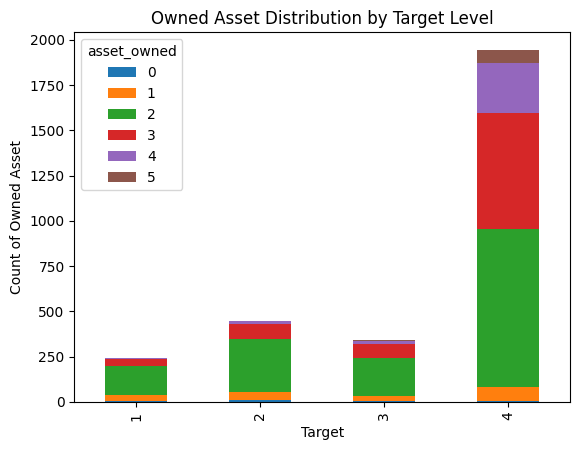

In [ ]:
grouped_data_asset = HH_head_data_cleaned.groupby(['Target', 'asset_owned']).size().reset_index(name='count')
pivot_table_asset = grouped_data_asset.pivot_table(index='Target', columns='asset_owned', values='count', fill_value=0)
ax = pivot_table_asset.plot.bar(stacked=True)
ax.set_xlabel('Target')
ax.set_ylabel('Count of Owned Asset')
ax.set_title('Owned Asset Distribution by Target Level')
plt.show()

Target, an ordinal variable indicating groups of income levels.

1 = extreme poverty

2 = moderate poverty

3 = vulnerable households

4 = non vulnerable households

we can tell from the bar chart, non vulnerable households own much more assets than the other targets, which indicates it can be a good feature to be added into model.

##Access to basic amenities
* water provision
* sanitation
* cooking energy
* electricity

###water provision
We need to make an ordinal variable to combine three variables that are related to water provision in the dataset: abastaguadentro (=1 if water provision inside the dwelling), abastaguafuera(=1 if water provision outside the dwelling), and abastaguano(=1 if water provision outside the dwelling).

In [ ]:
def water_provision_category(row):
    if row['abastaguadentro'] == 1:
        return 1  # Water provision inside the dwelling
    elif row['abastaguafuera'] == 1:
        return 2  # Water provision outside the dwelling
    else:
        return 0

# Creating a new ordinal variable 'water_provision'
HH_head_data_cleaned['water_provision'] = HH_head_data_cleaned.apply(water_provision_category, axis=1)

<ipython-input-95-8d098557d734>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  HH_head_data_cleaned['water_provision'] = HH_head_data_cleaned.apply(water_provision_category, axis=1)


In [ ]:
grouped_data_percentage_water = HH_head_data_cleaned.groupby(['Target', 'water_provision']).size().reset_index(name='count')
pivot_table_percentage_water = grouped_data_percentage_water.pivot_table(index='Target', columns='water_provision', values='count', fill_value=0)
pivot_table_percentage_water_table = pivot_table_percentage_water.div(pivot_table_percentage_water.sum(axis=1), axis=0) * 100
#percentage of each type of water provision for each target label

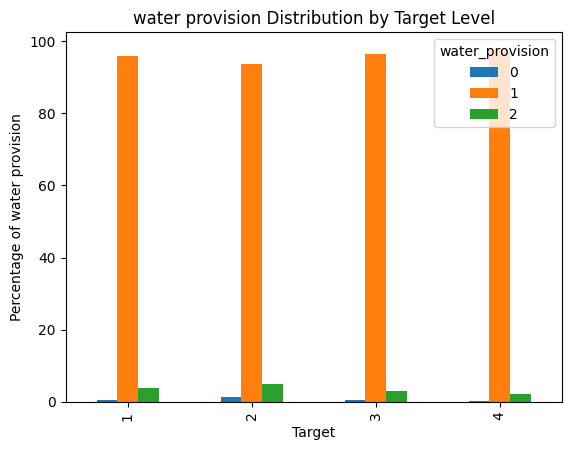

In [ ]:
ax = pivot_table_percentage_water_table.plot.bar()
ax.set_xlabel('Target')
ax.set_ylabel('Percentage of water provision')
ax.set_title('water provision Distribution by Target Level')
plt.show()

###Sanitation type

Then, we need to make an ordinal variable by combining five variables that are related to sanitation:
*  sanitario2, =1 toilet connected to sewer or cesspool
*  sanitario3, =1 toilet connected to  septic tank
*  sanitario5, =1 toilet connected to black hole or letrine
*  sanitario6, =1 toilet connected to other system

In [ ]:
HH_head_data_cleaned.loc[:, 'toilet'] = HH_head_data_cleaned.loc[:, 'sanitario1'] + HH_head_data_cleaned.loc[:, 'sanitario2'] + HH_head_data_cleaned.loc[:, 'sanitario3'] + HH_head_data_cleaned.loc[:, 'sanitario5']+  HH_head_data_cleaned.loc[:, 'sanitario6']
HH_head_data_cleaned.loc[:, ['toilet']].value_counts()

#it indicates each household only has one category for sanitary status which is what we want

<ipython-input-98-a9e815f9c29f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  HH_head_data_cleaned.loc[:, 'toilet'] = HH_head_data_cleaned.loc[:, 'sanitario1'] + HH_head_data_cleaned.loc[:, 'sanitario2'] + HH_head_data_cleaned.loc[:, 'sanitario3'] + HH_head_data_cleaned.loc[:, 'sanitario5']+  HH_head_data_cleaned.loc[:, 'sanitario6']


toilet
1         2973
dtype: int64

In [ ]:
def sanitario_category(row):
    if row['sanitario2'] == 1:
        return 2  # Toilet connected to sewer or cesspool
    elif row['sanitario3'] == 1:
        return 3  # Toilet connected to septic tank
    elif row['sanitario5'] == 1:
        return 4  # Toilet connected to black hole or letrine
    elif row['sanitario6'] == 1:
        return 5  # Toilet connected to other system
    else:
        return 0

# Creating a new ordinal variable 'sanitario_type'
HH_head_data_cleaned['sanitario_type'] = HH_head_data_cleaned.apply(sanitario_category, axis=1)

<ipython-input-99-8719cd7d4e78>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  HH_head_data_cleaned['sanitario_type'] = HH_head_data_cleaned.apply(sanitario_category, axis=1)


###electricity
Then, we need to make a categorical variable for electricity
* public	=1 electricity from CNFL,  ICE,  ESPH/JASEC
* planpri	=1 electricity from private plant
* coopele	=1 electricity from cooperative

In [ ]:
def electricity_source_category(row):
    if row['public'] == 1:
        return 'CNFL, ICE, ESPH/JASEC'
    elif row['planpri'] == 1:
        return 'private plant'
    elif row['coopele'] == 1:
        return 'cooperative'
    else:
        return 'unknown'  # No data or invalid data

# Creating a new categorical variable 'electricity_source'
HH_head_data_cleaned['electricity_source'] = HH_head_data_cleaned.apply(electricity_source_category, axis=1)

<ipython-input-100-9b47c81da025>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  HH_head_data_cleaned['electricity_source'] = HH_head_data_cleaned.apply(electricity_source_category, axis=1)


In [ ]:
electricity_source = HH_head_data_cleaned.groupby(['Target', 'electricity_source']).size().reset_index(name='count')
pivot_table_percentage_elec = electricity_source.pivot_table(index='Target', columns='electricity_source', values='count', fill_value=0)
pivot_table_percentage_elec_table = pivot_table_percentage_elec.div(pivot_table_percentage_elec.sum(axis=1), axis=0) * 100
pivot_table_percentage_elec_table

electricity_source,"CNFL, ICE, ESPH/JASEC",cooperative,private plant,unknown
Target,,,,
1,86.363636,11.983471,0.000000,1.652893
2,88.366890,10.290828,0.223714,1.118568
3,87.020649,12.979351,0.000000,0.000000
4,89.254499,10.488432,0.051414,0.205656


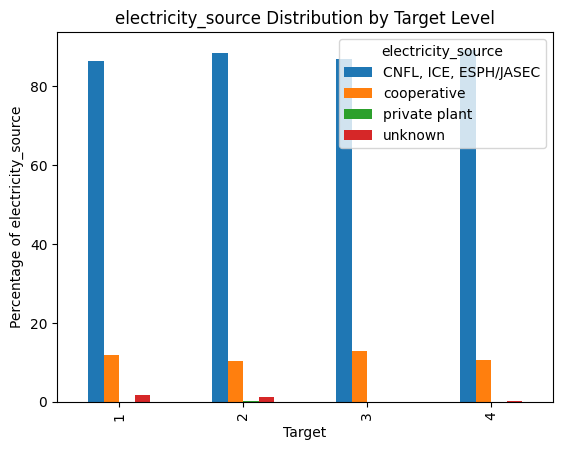

In [ ]:
ax = pivot_table_percentage_elec_table.plot.bar()
ax.set_xlabel('Target')
ax.set_ylabel('Percentage of electricity_source')
ax.set_title('electricity_source Distribution by Target Level')
plt.show()

Export dataset

In [ ]:
HH_head_data_cleaned.to_csv("HH_head_cleaned_data.csv", index=False)

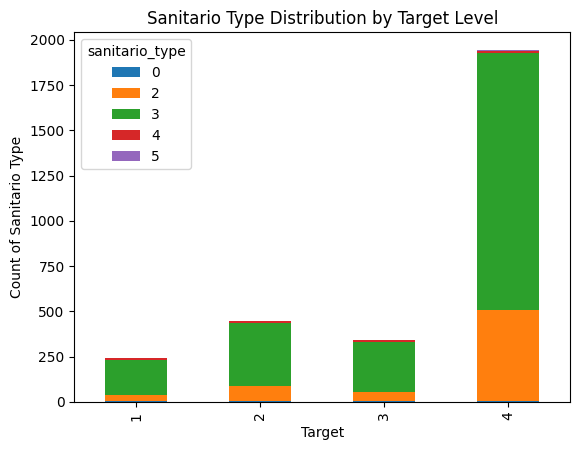

In [ ]:
grouped_data_sanitario = HH_head_data_cleaned.groupby(['Target', 'sanitario_type']).size().reset_index(name='count')
pivot_table_sanitario = grouped_data_sanitario.pivot_table(index='Target', columns='sanitario_type', values='count', fill_value=0)
ax = pivot_table_sanitario.plot.bar(stacked=True)
ax.set_xlabel('Target')
ax.set_ylabel('Count of Sanitario Type')
ax.set_title('Sanitario Type Distribution by Target Level')
plt.show()

There are predominantly having toilet connected to septic tank and black hole or letrine so I want to try to exclude these two types to observe the situation of household that does not have toilet

In [ ]:
grouped_data_percentage = HH_head_data_cleaned.groupby(['Target', 'sanitario_type']).size().reset_index(name='count')
pivot_table_percentage = grouped_data_percentage.pivot_table(index='Target', columns='sanitario_type', values='count', fill_value=0)

# Normalizing the counts to get the percentage
percentage_table = pivot_table_percentage.div(pivot_table_percentage.sum(axis=1), axis=0) * 100
percentage_table

sanitario_type,0,2,3,4,5
Target,,,,,
1,1.239669,14.462810,79.752066,4.132231,0.413223
2,0.894855,18.344519,78.076063,2.237136,0.447427
3,0.884956,14.749263,82.300885,2.064897,0.000000
4,0.257069,25.809769,73.110540,0.616967,0.205656


an ordinal variable called cooking_energy:
* energcocinar2	=1 main source of energy used for cooking electricity
* energcocinar3	=1 main source of energy used for cooking gas
* energcocinar4	=1 main source of energy used for cooking wood charcoal

In [ ]:
def cooking_energy_category(row):
    if row['energcocinar2'] == 1:
        return 2  # Main source of energy used for cooking electricity
    elif row['energcocinar3'] == 1:
        return 3  # Main source of energy used for cooking gas
    elif row['energcocinar4'] == 1:
        return 4  # Main source of energy used for cooking wood charcoal
    else:
        return 0

# Creating a new ordinal variable 'cooking_energy'
HH_head_data_cleaned['cooking_energy'] = HH_head_data_cleaned.apply(cooking_energy_category, axis=1)

<ipython-input-106-dd87233e7a2d>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  HH_head_data_cleaned['cooking_energy'] = HH_head_data_cleaned.apply(cooking_energy_category, axis=1)


In [ ]:
grouped_data_percentage_cook = HH_head_data_cleaned.groupby(['Target', 'cooking_energy']).size().reset_index(name='count')
pivot_table_percentage_cook = grouped_data_percentage_cook.pivot_table(index='Target', columns='cooking_energy', values='count', fill_value=0)
pivot_table_percentage_cook.div(pivot_table_percentage_cook.sum(axis=1), axis=0) * 100
#percentage of each type of cooking energy for each target label

cooking_energy,0,2,3,4
Target,,,,
1,1.652893,33.471074,52.066116,12.809917
2,0.671141,39.597315,50.559284,9.172260
3,0.884956,44.247788,48.672566,6.194690
4,0.257069,56.143959,41.285347,2.313625


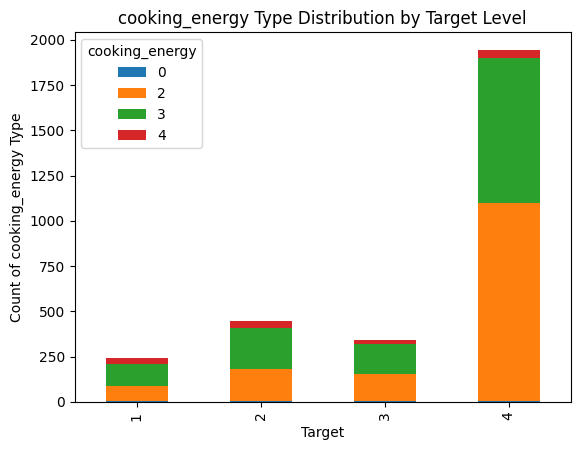

In [ ]:
grouped_data_cook = HH_head_data_cleaned.groupby(['Target', 'cooking_energy']).size().reset_index(name='count')
pivot_table_cook = grouped_data_cook.pivot_table(index='Target', columns='cooking_energy', values='count', fill_value=0)
ax = pivot_table_cook.plot.bar(stacked=True)
ax.set_xlabel('Target')
ax.set_ylabel('Count of cooking_energy Type')
ax.set_title('cooking_energy Type Distribution by Target Level')
plt.show()

##education level
categorical education level

instlevel1	=1 no level of education
instlevel2	=1 incomplete primary
instlevel3	=1 complete primary
instlevel4	=1 incomplete academic secondary level
instlevel5	=1 complete academic secondary level
instlevel6	=1 incomplete technical secondary level
instlevel7	=1 complete technical secondary level
instlevel8	=1 undergraduate and higher education
instlevel9	=1 postgraduate higher education

In [ ]:
def education_level_category(row):
    if row['instlevel1'] == 1:
        return 'no level of education'
    elif row['instlevel2'] == 1:
        return 'incomplete primary'
    elif row['instlevel3'] == 1:
        return 'complete primary'
    elif row['instlevel4'] == 1:
        return 'incomplete academic secondary level'
    elif row['instlevel5'] == 1:
        return 'complete academic secondary level'
    elif row['instlevel6'] == 1:
        return 'incomplete technical secondary level'
    elif row['instlevel7'] == 1:
        return 'complete technical secondary level'
    elif row['instlevel8'] == 1:
        return 'undergraduate and higher education'
    elif row['instlevel9'] == 1:
        return 'postgraduate higher education'
    else:
        return 'unknown'  # No data or invalid data

# Creating a new categorical variable 'education_level'
HH_head_data_cleaned['education_level'] = HH_head_data_cleaned.apply(education_level_category, axis=1)


<ipython-input-109-59cebfb39e8b>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  HH_head_data_cleaned['education_level'] = HH_head_data_cleaned.apply(education_level_category, axis=1)


In [ ]:
edu = HH_head_data_cleaned.groupby(['Target', 'education_level']).size().reset_index(name='count')
pivot_table_percentage_edu = edu.pivot_table(index='Target', columns='education_level', values='count', fill_value=0)
pivot_table_percentage_edu.div(pivot_table_percentage_edu.sum(axis=1), axis=0) * 100

education_level,complete academic secondary level,complete primary,complete technical secondary level,incomplete academic secondary level,incomplete primary,incomplete technical secondary level,no level of education,postgraduate higher education,undergraduate and higher education,unknown
Target,,,,,,,,,,
1,9.090909,27.272727,0.413223,21.487603,29.338843,0.413223,9.090909,0.000000,2.892562,0.000000
2,8.277405,35.570470,0.223714,17.002237,26.845638,0.223714,8.948546,0.223714,2.684564,0.000000
3,8.554572,35.103245,0.294985,15.634218,25.663717,0.884956,8.554572,0.294985,5.014749,0.000000
4,13.624679,25.347044,1.645244,17.120823,11.465296,0.771208,1.953728,4.421594,23.598972,0.051414


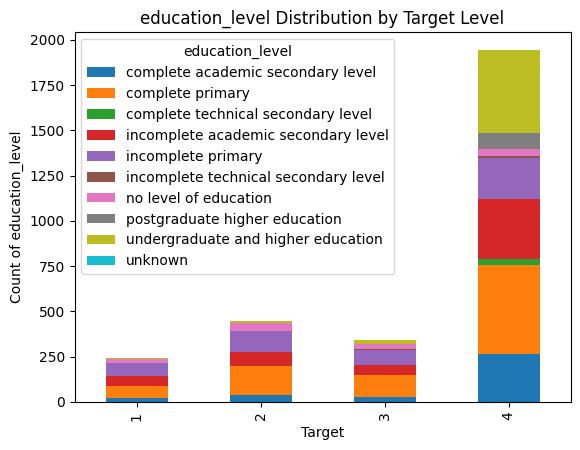

In [ ]:
pivot_table_edu = edu.pivot_table(index='Target', columns='education_level', values='count', fill_value=0)
ax = pivot_table_edu.plot.bar(stacked=True)
ax.set_xlabel('Target')
ax.set_ylabel('Count of education_level')
ax.set_title('education_level Distribution by Target Level')
plt.show()

#we can observe that head of household with a education level of undergraduate and higher education have less poverty.
#We can see a clear trend for different target labels
#instlevel8 is a good feature to be kept in the dataset for model testing

Wall material

paredblolad	=1 if predominant material on the outside wall is block or brick
paredzocalo	=1 if predominant material on the outside wall is socket (wood,  zinc or absbesto
paredpreb	=1 if predominant material on the outside wall is prefabricated or cement
pareddes	=1 if predominant material on the outside wall is waste material
paredmad	=1 if predominant material on the outside wall is wood
paredzinc	=1 if predominant material on the outside wall is zink
paredfibras	=1 if predominant material on the outside wall is natural fibers
paredother	=1 if predominant material on the outside wall is other

In [ ]:
def wall_material_category(row):
    if row['paredblolad'] == 1:
        return 'block or brick'
    elif row['paredzocalo'] == 1:
        return 'socket (wood, zinc or asbestos)'
    elif row['paredpreb'] == 1:
        return 'prefabricated or cement'
    elif row['pareddes'] == 1:
        return 'waste material'
    elif row['paredmad'] == 1:
        return 'wood'
    elif row['paredzinc'] == 1:
        return 'zinc'
    elif row['paredfibras'] == 1:
        return 'natural fibers'
    elif row['paredother'] == 1:
        return 'other'
    else:
        return 'unknown'  # No data or invalid data

# Creating a new categorical variable 'wall_material'
HH_head_data_cleaned['wall_material'] = HH_head_data_cleaned.apply(wall_material_category, axis=1)


<ipython-input-112-0b0edbed7456>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  HH_head_data_cleaned['wall_material'] = HH_head_data_cleaned.apply(wall_material_category, axis=1)


In [ ]:
wall_material = HH_head_data_cleaned.groupby(['Target', 'wall_material']).size().reset_index(name='count')
pivot_table_percentage_wall = wall_material.pivot_table(index='Target', columns='wall_material', values='count', fill_value=0)
pivot_table_percentage_wall_table = pivot_table_percentage_wall.div(pivot_table_percentage_wall.sum(axis=1), axis=0) * 100
pivot_table_percentage_wall_table

wall_material,block or brick,natural fibers,other,prefabricated or cement,"socket (wood, zinc or asbestos)",waste material,wood,zinc
Target,,,,,,,,
1,36.776860,0.826446,0.000000,26.859504,10.743802,2.479339,20.247934,2.066116
2,40.939597,0.223714,0.223714,23.042506,12.080537,2.460850,19.239374,1.789709
3,51.622419,0.000000,0.000000,23.598820,8.259587,1.179941,15.044248,0.294985
4,69.254499,0.102828,0.154242,15.269923,6.323907,0.205656,7.866324,0.822622


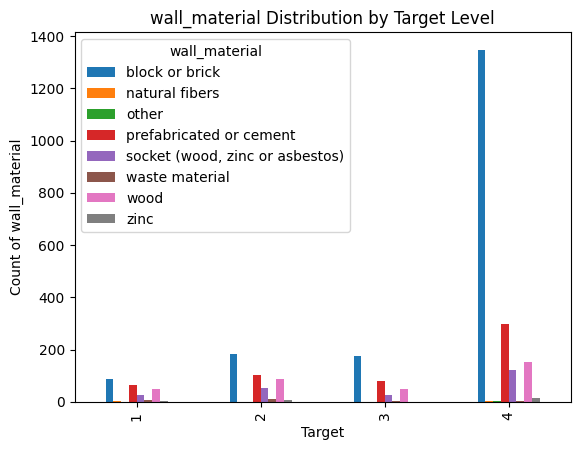

In [ ]:
pivot_table_wall = wall_material.pivot_table(index='Target', columns='wall_material', values='count', fill_value=0)
ax = pivot_table_wall.plot.bar(stacked=False)
ax.set_xlabel('Target')
ax.set_ylabel('Count of wall_material')
ax.set_title('wall_material Distribution by Target Level')
plt.show()

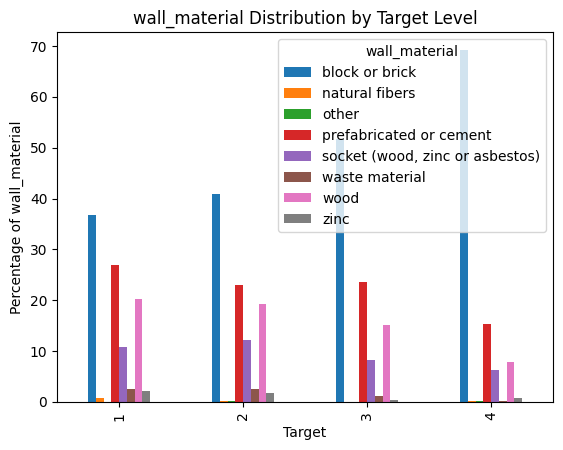

In [ ]:
ax = pivot_table_percentage_wall_table.plot.bar()
ax.set_xlabel('Target')
ax.set_ylabel('Percentage of wall_material')
ax.set_title('wall_material Distribution by Target Level')
plt.show()

##housing_situation
create a new categorical variable called 'housing_situation'

tipovivi1	=1 own and fully paid house
tipovivi2	=1 own,  paying in installments
tipovivi3	=1 rented
tipovivi4	=1 precarious
tipovivi5	=1 other(assigned,  borrowed)

In [ ]:
def housing_situation_category(row):
    if row['tipovivi1'] == 1:
        return 'own and fully paid'
    elif row['tipovivi2'] == 1:
        return 'own, paying in installments'
    elif row['tipovivi3'] == 1:
        return 'rented'
    elif row['tipovivi4'] == 1:
        return 'precarious'
    elif row['tipovivi5'] == 1:
        return 'other (assigned, borrowed)'
    else:
        return 'unknown'  # No data or invalid data

# Creating a new categorical variable 'housing_situation'
HH_head_data_cleaned['housing_situation'] = HH_head_data_cleaned.apply(housing_situation_category, axis=1)

<ipython-input-116-e0bf91ec88df>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  HH_head_data_cleaned['housing_situation'] = HH_head_data_cleaned.apply(housing_situation_category, axis=1)


In [ ]:
housing = HH_head_data_cleaned.groupby(['Target', 'housing_situation']).size().reset_index(name='count')
pivot_table_percentage_housing = housing.pivot_table(index='Target', columns='housing_situation', values='count', fill_value=0)
pivot_table_percentage_housing_table = pivot_table_percentage_housing.div(pivot_table_percentage_housing.sum(axis=1), axis=0) * 100
pivot_table_percentage_housing_table

housing_situation,"other (assigned, borrowed)",own and fully paid,"own, paying in installments",precarious,rented
Target,,,,,
1,12.396694,64.876033,3.305785,4.545455,14.876033
2,13.870246,63.087248,2.684564,3.355705,17.002237
3,10.029499,65.191740,6.194690,2.359882,16.224189
4,6.580977,61.491003,12.287918,0.616967,19.023136


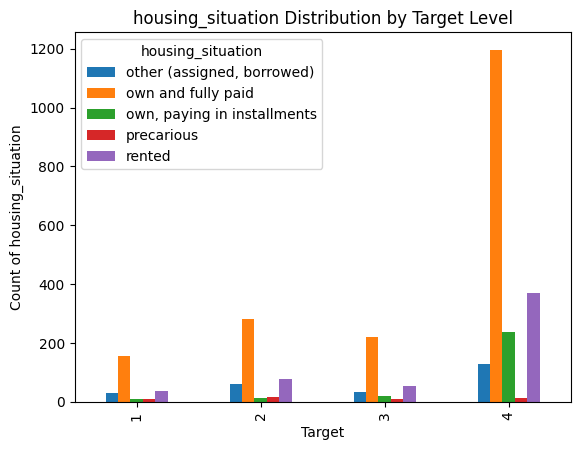

In [ ]:
pivot_table_housing = housing.pivot_table(index='Target', columns='housing_situation', values='count', fill_value=0)
ax = pivot_table_housing.plot.bar()
ax.set_xlabel('Target')
ax.set_ylabel('Count of housing_situation')
ax.set_title('housing_situation Distribution by Target Level')
plt.show()

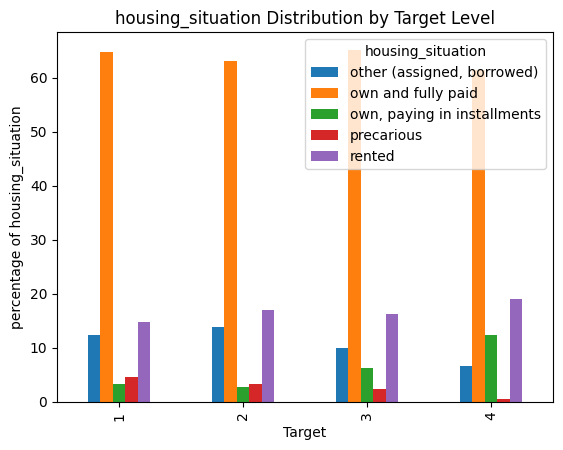

In [ ]:
ax = pivot_table_percentage_housing_table.plot.bar()
ax.set_xlabel('Target')
ax.set_ylabel('percentage of housing_situation')
ax.set_title('housing_situation Distribution by Target Level')
plt.show()

##wall_status
epared1	=1 if walls are bad
epared2	=1 if walls are regular
epared3	=1 if walls are good

In [ ]:
def wall_status_category(row):
    if row['epared1'] == 1:
        return 'bad'
    elif row['epared2'] == 1:
        return 'regular'
    elif row['epared3'] == 1:
        return 'good'
    else:
        return 'unknown'  # No data or invalid data

# Creating a new categorical variable 'wall_status'
HH_head_data_cleaned['wall_status'] = HH_head_data_cleaned.apply(wall_status_category, axis=1)

<ipython-input-120-16ea351d3552>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  HH_head_data_cleaned['wall_status'] = HH_head_data_cleaned.apply(wall_status_category, axis=1)


In [ ]:
wall_status = HH_head_data_cleaned.groupby(['Target', 'wall_status']).size().reset_index(name='count')
wall_status_pivot = wall_status.pivot_table(index='Target', columns='wall_status', values='count', fill_value=0)
wall_status_pivot_table = wall_status_pivot.div(wall_status_pivot.sum(axis=1), axis=0) * 100
wall_status_pivot_table

wall_status,bad,good,regular
Target,,,
1,23.140496,32.231405,44.628099
2,19.686801,37.136465,43.176734
3,13.274336,50.737463,35.988201
4,5.912596,68.483290,25.604113


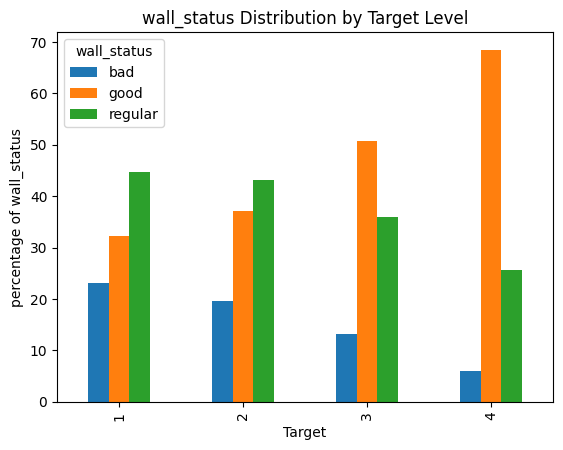

In [ ]:
ax = wall_status_pivot_table.plot.bar()
ax.set_xlabel('Target')
ax.set_ylabel('percentage of wall_status')
ax.set_title('wall_status Distribution by Target Level')
plt.show()

##floor material

pisomoscer	=1 if predominant material on the floor is mosaic,  ceramic,  terrazo
pisocemento	=1 if predominant material on the floor is cement
pisoother	=1 if predominant material on the floor is other
pisonatur	=1 if predominant material on the floor is  natural material
pisonotiene	=1 if no floor at the household
pisomadera	=1 if predominant material on the floor is wood

In [ ]:
def floor_material_category(row):
    if row['pisomoscer'] == 1:
        return 'mosaic, ceramic, terrazo'
    elif row['pisocemento'] == 1:
        return 'cement'
    elif row['pisoother'] == 1:
        return 'other'
    elif row['pisonatur'] == 1:
        return 'natural material'
    elif row['pisomadera'] == 1:
        return 'wood'
    else:
        return 'unknown'  # No data or invalid data

# Creating a new categorical variable 'floor_material'
HH_head_data_cleaned['floor_material'] = HH_head_data_cleaned.apply(floor_material_category, axis=1)

<ipython-input-123-45e05f7e927f>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  HH_head_data_cleaned['floor_material'] = HH_head_data_cleaned.apply(floor_material_category, axis=1)


In [ ]:
floor_material = HH_head_data_cleaned.groupby(['Target', 'floor_material']).size().reset_index(name='count')
pivot_table_percentage_floor = floor_material.pivot_table(index='Target', columns='floor_material', values='count', fill_value=0)
pivot_table_percentage_floor_table = pivot_table_percentage_floor.div(pivot_table_percentage_floor.sum(axis=1), axis=0) * 100
pivot_table_percentage_floor_table

floor_material,cement,"mosaic, ceramic, terrazo",natural material,other,unknown,wood
Target,,,,,,
1,40.082645,45.454545,0.413223,0.000000,3.719008,10.330579
2,32.885906,52.125280,0.447427,0.000000,3.355705,11.185682
3,26.843658,62.831858,0.000000,0.000000,1.769912,8.554572
4,15.321337,79.434447,0.000000,0.102828,0.411311,4.730077


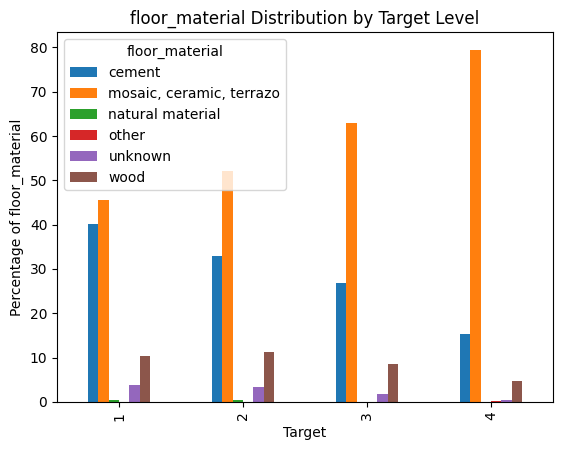

In [ ]:
ax = pivot_table_percentage_floor_table.plot.bar()
ax.set_xlabel('Target')
ax.set_ylabel('Percentage of floor_material')
ax.set_title('floor_material Distribution by Target Level')
plt.show()

##floor status
eviv1	=1 if floor are bad
eviv2	=1 if floor are regular
eviv3	=1 if floor are good

In [ ]:
def floor_status_category(row):
    if row['eviv1'] == 1:
        return 'bad'
    elif row['eviv2'] == 1:
        return 'regular'
    elif row['eviv3'] == 1:
        return 'good'
    else:
        return 'unknown'  # No data or invalid data

# Creating a new categorical variable 'floor_status'
HH_head_data_cleaned['floor_status'] = HH_head_data_cleaned.apply(floor_status_category, axis=1)

<ipython-input-126-73363250038f>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  HH_head_data_cleaned['floor_status'] = HH_head_data_cleaned.apply(floor_status_category, axis=1)


In [ ]:
floor_status = HH_head_data_cleaned.groupby(['Target', 'floor_status']).size().reset_index(name='count')
floor_status_pivot = floor_status.pivot_table(index='Target', columns='floor_status', values='count', fill_value=0)
floor_status_pivot_table = floor_status_pivot.div(floor_status_pivot.sum(axis=1), axis=0) * 100
floor_status_pivot_table

floor_status,bad,good,regular
Target,,,
1,21.074380,38.016529,40.909091
2,20.581655,44.966443,34.451902
3,11.799410,55.457227,32.743363
4,5.244216,75.526992,19.228792


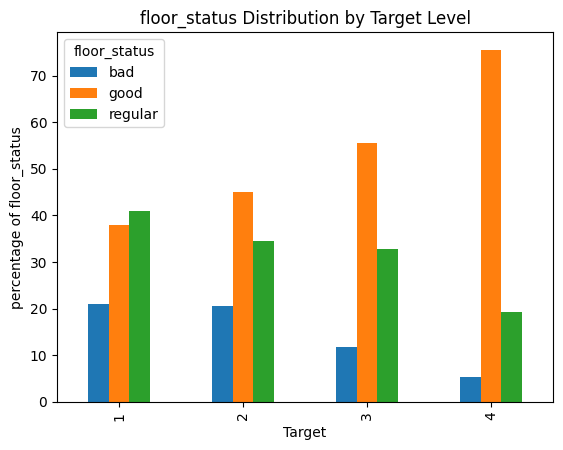

In [ ]:
ax = floor_status_pivot_table.plot.bar()
ax.set_xlabel('Target')
ax.set_ylabel('percentage of floor_status')
ax.set_title('floor_status Distribution by Target Level')
plt.show()

##roof material
techozinc	=1 if predominant material on the roof is metal foil or zink
techoentrepiso	=1 if predominant material on the roof is fiber cement,  mezzanine
techocane	=1 if predominant material on the roof is natural fibers
techootro	=1 if predominant material on the roof is other


In [ ]:
def roof_material_category(row):
    if row['techozinc'] == 1:
        return 'metal foil or zinc'
    elif row['techoentrepiso'] == 1:
        return 'fiber cement, mezzanine'
    elif row['techocane'] == 1:
        return 'natural fibers'
    elif row['techootro'] == 1:
        return 'other'
    else:
        return 'unknown'  # No data or invalid data

# Creating a new categorical variable 'roof_material'
HH_head_data_cleaned['roof_material'] = HH_head_data_cleaned.apply(roof_material_category, axis=1)

<ipython-input-129-72a42e7471ec>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  HH_head_data_cleaned['roof_material'] = HH_head_data_cleaned.apply(roof_material_category, axis=1)


In [ ]:
roof_material = HH_head_data_cleaned.groupby(['Target', 'roof_material']).size().reset_index(name='count')
pivot_table_percentage_roof = roof_material.pivot_table(index='Target', columns='roof_material', values='count', fill_value=0)
pivot_table_percentage_roof_table = pivot_table_percentage_roof.div(pivot_table_percentage_roof.sum(axis=1), axis=0) * 100
pivot_table_percentage_roof_table

roof_material,"fiber cement, mezzanine",metal foil or zinc,natural fibers,other,unknown
Target,,,,,
1,1.239669,95.454545,1.239669,0.000000,2.066116
2,2.013423,95.749441,0.223714,0.000000,2.013423
3,0.294985,99.410029,0.000000,0.000000,0.294985
4,2.622108,96.555270,0.257069,0.359897,0.205656


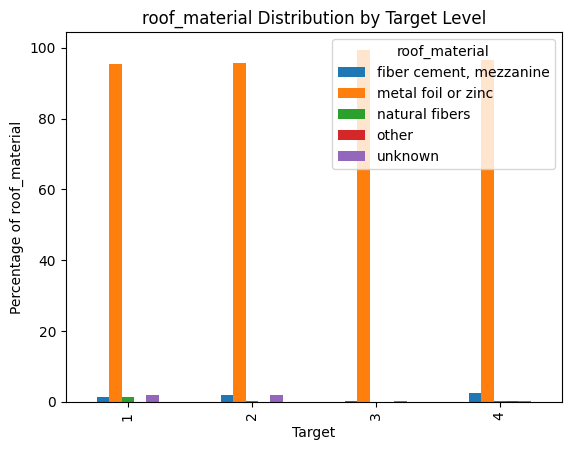

In [ ]:
ax = pivot_table_percentage_roof_table.plot.bar()
ax.set_xlabel('Target')
ax.set_ylabel('Percentage of roof_material')
ax.set_title('roof_material Distribution by Target Level')
plt.show()

In [ ]:
no_metal_foil = HH_head_data_cleaned.loc[(HH_head_data_cleaned.loc[:,'roof_material'] != 'metal foil or zinc'), :] #dominant so we removed it
roof_material = no_metal_foil.groupby(['Target', 'roof_material']).size().reset_index(name='count')
pivot_table_percentage_roof = roof_material.pivot_table(index='Target', columns='roof_material', values='count', fill_value=0)
pivot_table_percentage_roof_table = pivot_table_percentage_roof.div(pivot_table_percentage_roof.sum(axis=1), axis=0) * 100
pivot_table_percentage_roof_table

roof_material,"fiber cement, mezzanine",natural fibers,other,unknown
Target,,,,
1,27.272727,27.272727,0.000000,45.454545
2,47.368421,5.263158,0.000000,47.368421
3,50.000000,0.000000,0.000000,50.000000
4,76.119403,7.462687,10.447761,5.970149


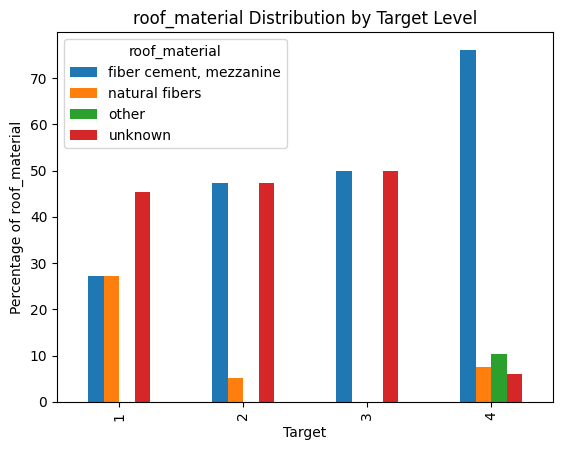

In [ ]:
ax = pivot_table_percentage_roof_table.plot.bar()
ax.set_xlabel('Target')
ax.set_ylabel('Percentage of roof_material')
ax.set_title('roof_material Distribution by Target Level')
plt.show()

##roof status

etecho1	=1 if roof are bad
etecho2	=1 if roof are regular
etecho3	=1 if roof are good

In [ ]:
def roof_status_category(row):
    if row['etecho1'] == 1:
        return 'bad'
    elif row['etecho2'] == 1:
        return 'regular'
    elif row['etecho3'] == 1:
        return 'good'
    else:
        return 'unknown'  # No data or invalid data

# Creating a new categorical variable 'roof_status'
HH_head_data_cleaned['roof_status'] = HH_head_data_cleaned.apply(roof_status_category, axis=1)

<ipython-input-134-a30e0cb59675>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  HH_head_data_cleaned['roof_status'] = HH_head_data_cleaned.apply(roof_status_category, axis=1)


In [ ]:
roof_status = HH_head_data_cleaned.groupby(['Target', 'roof_status']).size().reset_index(name='count')
roof_status_pivot = roof_status.pivot_table(index='Target', columns='roof_status', values='count', fill_value=0)
roof_status_pivot_table = roof_status_pivot.div(roof_status_pivot.sum(axis=1), axis=0) * 100
roof_status_pivot_table

roof_status,bad,good,regular
Target,,,
1,28.512397,33.057851,38.429752
2,22.147651,41.610738,36.241611
3,17.404130,46.312684,36.283186
4,8.483290,68.226221,23.290488


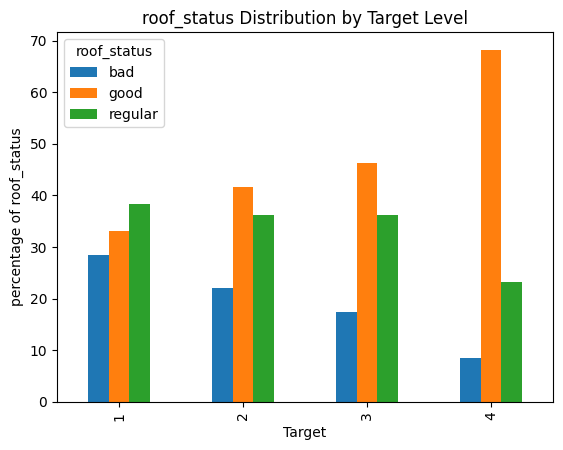

In [ ]:
ax = roof_status_pivot_table.plot.bar()
ax.set_xlabel('Target')
ax.set_ylabel('percentage of roof_status')
ax.set_title('roof_status Distribution by Target Level')
plt.show()

##marital status
estadocivil3	=1 if married
estadocivil4	=1 if divorced
estadocivil5	=1 if separated
estadocivil6	=1 if widow/er
estadocivil7	=1 if single

In [ ]:
def marital_status_category(row):
    if row['estadocivil3'] == 1:
        return 'married'
    elif row['estadocivil4'] == 1:
        return 'divorced'
    elif row['estadocivil5'] == 1:
        return 'separated'
    elif row['estadocivil6'] == 1:
        return 'widow/er'
    elif row['estadocivil7'] == 1:
        return 'single'
    else:
        return 'unknown'  # No data or invalid data

# Creating a new categorical variable 'marital_status'
HH_head_data_cleaned['marital_status'] = HH_head_data_cleaned.apply(marital_status_category, axis=1)

<ipython-input-137-16115703f7d2>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  HH_head_data_cleaned['marital_status'] = HH_head_data_cleaned.apply(marital_status_category, axis=1)


In [ ]:
marital_status = HH_head_data_cleaned.groupby(['Target', 'marital_status']).size().reset_index(name='count')
pivot_table_percentage_marital = marital_status.pivot_table(index='Target', columns='marital_status', values='count', fill_value=0)
pivot_table_percentage_marital_table = pivot_table_percentage_marital.div(pivot_table_percentage_marital.sum(axis=1), axis=0) * 100
pivot_table_percentage_marital_table

marital_status,divorced,married,separated,single,unknown,widow/er
Target,,,,,,
1,4.545455,29.338843,28.512397,14.876033,17.768595,4.958678
2,3.579418,31.767338,15.883669,13.199105,24.161074,11.409396
3,4.719764,38.348083,12.094395,10.029499,22.418879,12.389381
4,9.151671,46.478149,10.488432,11.619537,14.550129,7.712082


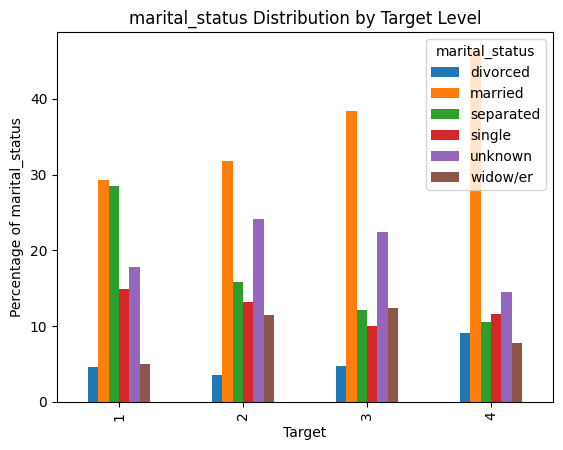

In [ ]:
ax = pivot_table_percentage_marital_table.plot.bar()
ax.set_xlabel('Target')
ax.set_ylabel('Percentage of marital_status')
ax.set_title('marital_status Distribution by Target Level')
plt.show()

In [ ]:
HH_head_data_cleaned['parentesco7'].value_counts()

0    2973
Name: parentesco7, dtype: int64

##test if we need the columns:

parentesco1	=1 if household head
parentesco2	=1 if spouse/partner
parentesco3	=1 if son/doughter
parentesco4	=1 if stepson/doughter
parentesco5	=1 if son/doughter in law
parentesco6	=1 if grandson/doughter
parentesco7	=1 if mother/father
parentesco8	=1 if father/mother in law
parentesco9	=1 if brother/sister
parentesco10	=1 if brother/sister in law
parentesco11	=1 if other family member
parentesco12	=1 if other non family member

In [ ]:
def relationship_category(row):
    if row['parentesco1'] == 1:
        return 'head of household'
    elif row['parentesco2'] == 1:
        return 'spouse/partner'
    elif row['parentesco3'] == 1:
        return 'son/daughter'
    elif row['parentesco4'] == 1:
        return 'stepson/daughter'
    elif row['parentesco5'] == 1:
        return 'son/daughter in law'
    elif row['parentesco6'] == 1:
        return 'grandson/daughter'
    elif row['parentesco7'] == 1:
        return 'mother/father'
    elif row['parentesco8'] == 1:
        return 'father/mother in law'
    elif row['parentesco9'] == 1:
        return 'brother/sister'
    elif row['parentesco10'] == 1:
        return 'brother/sister in law'
    elif row['parentesco11'] == 1:
        return 'other family member'
    elif row['parentesco12'] == 1:
        return 'other non-family member'
    else:
        return 0

HH_head_data_cleaned['relationship'] = HH_head_data_cleaned.apply(relationship_category, axis=1)
HH_head_data_cleaned['relationship'].value_counts()

#the variables are not informative so we decide to exclude them

<ipython-input-141-92c83aff3aa7>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  HH_head_data_cleaned['relationship'] = HH_head_data_cleaned.apply(relationship_category, axis=1)


head of household    2973
Name: relationship, dtype: int64

##rubbish disposal

elimbasu1	=1 if rubbish disposal mainly by tanker truck
elimbasu2	=1 if rubbish disposal mainly by botan hollow or buried
elimbasu3	=1 if rubbish disposal mainly by burning
elimbasu4	=1 if rubbish disposal mainly by throwing in an unoccupied space
elimbasu5	=1 if rubbish disposal mainly by throwing in river,  creek or sea
elimbasu6	=1 if rubbish disposal mainly other

In [ ]:
def rubbish_disposal_category(row):
    if row['elimbasu1'] == 1:
        return 'tanker truck'
    elif row['elimbasu2'] == 1:
        return 'botan hollow or buried'
    elif row['elimbasu3'] == 1:
        return 'burning'
    elif row['elimbasu4'] == 1:
        return 'throwing in unoccupied space'
    elif row['elimbasu5'] == 1:
        return 'throwing in river, creek, or sea'
    elif row['elimbasu6'] == 1:
        return 'other'
    else:
        return 'unknown'  # No data or invalid data

# Creating a new categorical variable 'rubbish_disposal'
HH_head_data_cleaned['rubbish_disposal'] = HH_head_data_cleaned.apply(rubbish_disposal_category, axis=1)

<ipython-input-142-5688675bfff1>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  HH_head_data_cleaned['rubbish_disposal'] = HH_head_data_cleaned.apply(rubbish_disposal_category, axis=1)


In [ ]:
rubbish_disposal = HH_head_data_cleaned.groupby(['Target', 'rubbish_disposal']).size().reset_index(name='count')
pivot_table_percentage_rubbish = rubbish_disposal.pivot_table(index='Target', columns='rubbish_disposal', values='count', fill_value=0)
pivot_table_percentage_rubbish_table = pivot_table_percentage_rubbish.div(pivot_table_percentage_rubbish.sum(axis=1), axis=0) * 100
pivot_table_percentage_rubbish_table

rubbish_disposal,botan hollow or buried,burning,other,tanker truck,throwing in unoccupied space
Target,,,,,
1,4.545455,16.115702,0.000000,79.338843,0.000000
2,4.921700,13.422819,0.000000,80.760626,0.894855
3,3.834808,12.094395,0.000000,84.070796,0.000000
4,2.262211,5.398458,0.205656,92.133676,0.000000


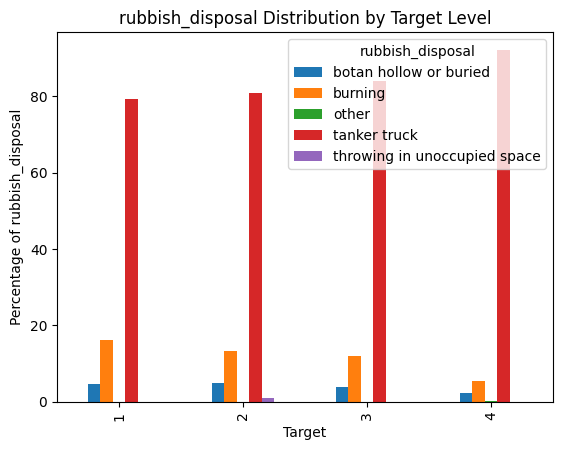

In [ ]:
ax = pivot_table_percentage_rubbish_table.plot.bar()
ax.set_xlabel('Target')
ax.set_ylabel('Percentage of rubbish_disposal')
ax.set_title('rubbish_disposal Distribution by Target Level')
plt.show()

#New dataset with generated features for model testing

In [ ]:
print(HH_head_data_cleaned.columns)

Index(['Id', 'v2a1', 'hacdor', 'rooms', 'hacapo', 'v14a', 'refrig', 'v18q',
       'v18q1', 'r4h1',
       ...
       'wall_material', 'housing_situation', 'wall_status', 'floor_material',
       'floor_status', 'roof_material', 'roof_status', 'marital_status',
       'relationship', 'rubbish_disposal'],
      dtype='object', length=176)


In [ ]:
column_names_post_data = ['Id',
                 'v2a1',
                 'hacdor',
                 'rooms',
                 'hacapo',
                 'v14a',
                 'v18q1',
                 'r4h1',
                 'r4h2',
                 'r4h3',
                 'r4m1',
                 'r4m2',
                 'r4m3',
                 'r4t1',
                 'r4t2',
                 'r4t3',
                 'tamhog',
                 'tamviv',
                 'escolari',
                 'rez_esc',
                 'hhsize',
                 'wall_material',  #new feature
                 'floor_material', #new feature
                 'roof_material', #new feature
                 'marital_status',#new feature
                 'rubbish_disposal', #new feature
                 'pisonotiene',
                 'cielorazo',
                 'water_provision', #new feature
                 'abastaguano',
                 'noelec',
                 'sanitario1',
                 'electricity_source', #new feature
                 'wall_status',#new feature
                 'roof_status', #new feature
                 'floor_status',#new feature
                 'dis',
                 'male', #gender indicator, =1 male, =0 female
                 'estadocivil1',
                 'estadocivil2',
                 'idhogar',
                 'hogar_nin',
                 'hogar_adul',
                 'hogar_mayor',
                 'hogar_total',
                 'dependency',
                 'edjefe',
                 'edjefa',
                 'meaneduc',
                 'instlevel1',
                 'instlevel8',
                 'bedrooms',
                 'overcrowding',
                 'asset_owned', #new feature
                 'qmobilephone',
                 'region',#new feature
                 'Central',
                 'Chorotega',
                 'Paci­fico Central',
                 'Brunca',
                 'Huetar Atlantica',
                 'Huetar Norte',
                 'area1', #urban or rural area indicator, =1 urban
                 'age',
                 'SQBescolari',
                 'SQBage',
                 'SQBhogar_total',
                 'SQBedjefe',
                 'SQBhogar_nin',
                 'SQBovercrowding',
                 'SQBdependency',
                 'SQBmeaned',
                 'agesq',
                 'mean_per_capita_income', # new feature
                 'yrs_edu_lost', # new feature
                 'mobilephone_per_capita', # new feature
                 'computer_per_capita', # new feature
                 'tablet_per_capita', # new feature
                 'estimated_household_income_min', # new feature GH after checkpoint 2
                 'estimated_household_income_max', # new feature GH after checkpoint 2
                 'rent_to_income_ratio_min', # new feature GH after checkpoint 2
                 'rent_to_income_ratio_max', # new feature GH after checkpoint 2
                 'HCB_cost_burdened_min', # new feature GH after checkpoint 2
                 'HCB_cost_burdened_max', # new feature GH after checkpoint 2
                 'HCB_severely_cost_burdened_min', # new feature GH after checkpoint 2
                 'HCB_severely_cost_burdened_max', # new feature GH after checkpoint 2
                 'Target'
                 ]


In [ ]:
post_HH_data = HH_head_data_cleaned.loc[:, column_names_post_data]
post_HH_data.shape

(2973, 87)

In [ ]:
from google.colab import files
post_HH_data.to_csv('postHHdata.csv', encoding = 'utf-8-sig')
files.download('postHHdata.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
sum(post_HH_data['v2a1'].isna())

0

In [ ]:
post_HH_data.to_csv("postHHdata.csv")